In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
import numpy as np

# Additional imports
import pystac_client
import xarray as xr
import pathlib
import os
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm

import webbrowser
from pathlib import Path
import os
import time

from itertools import compress
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from tqdm import tqdm

from shapely.geometry import box



In [2]:
# opening STAC catalog

catalog = pystac_client.Client.open(
    #"https://storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json" # cloud API
    "https://storage.googleapis.com/dgds-data-public/gca/SOTC/gca-stac_sotc/catalog.json" # P drive API 
)
#catalog

In [3]:
list(catalog.get_children())

[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=world_pop>,
 <CollectionClient id=world_gdp>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>,
 <CollectionClient id=sub_threat>,
 <CollectionClient id=Exp_world_pop>,
 <CollectionClient id=Exp_world_pop_parquet>,
 <CollectionClient id=Haz-ESL>,
 <CollectionClient id=Vul-Inf_Mort>,
 <CollectionClient id=Haz-GCM_90-100>,
 <CollectionClient id=Exp-NS_Slopes>,
 <CollectionClient id=Vul_MYS>,
 <CollectionClient id=Vul_RS>,
 <CollectionClient id=Haz-GCM_40-50>,
 <CollectionClient id=Haz-ERA5_04-14>,
 <CollectionClient id=Vul-GDP_Cap>,
 <CollectionClient id=Haz-GCM_04-14>,
 <CollectionClient id=Haz-Land_Sub_2010_COGs>,
 <CollectionClient id=Haz-Land_Sub_2040_COGs>,
 <CollectionClient id=Vul-Roads_Density_COGs>,
 <CollectionClient id=Exp-Delta_DEM_COGs>,
 <CollectionClient id=Haz-ERA5_93-23>,
 <CollectionC

In [4]:
href = catalog.get_child("shore_mon_fut").assets["data"].href
ds = xr.open_zarr(href)
ds=ds.compute()
ds

<xarray.Dataset>
Dimensions:        (stations: 504815, time: 4)
Coordinates:
    continent      (stations) |S23 b'South America' ... b'Europe'
    country        (stations) |S40 b'Chile' b'Chile' ... b'Russia' b'Russia'
    country_id     (stations) |S7 b'CHL' b'CHL' b'CHL' ... b'RUS' b'RUS' b'RUS'
    lat            (stations) float64 -50.38 -50.38 -50.49 ... 64.7 64.7 64.7
    lon            (stations) float64 -74.38 -74.3 -74.18 ... 39.88 39.88 39.87
  * time           (time) datetime64[ns] 1984-01-01 2021-01-01 ... 2100-01-01
    transect_geom  (stations) |S92 b'LINESTRING (-74.382468591 -50.3791437735...
    transect_id    (stations) |S15 b'BOX_028_183_1' ... b'BOX_211_067_135'
Dimensions without coordinates: stations
Data variables:
    changerate     (stations) float64 6.937 1.08 0.1039 ... 0.1558 0.02817
    intercept      (stations) float64 297.4 464.4 611.4 ... 349.2 367.9 369.6
    sp_ambient     (stations, time) float64 0.0 256.7 457.9 ... 1.859 3.267
    sp_rcp45_p5    (stations, time) float64 0.0 256.7 456.2 ... -66.91 -149.7
    sp_rcp45_p50   (stations, time) float64 0.0 256.7 457.1 ... -33.15 -63.71
    sp_rcp45_p95   (stations, time) float64 0.0 256.7 457.7 ... -10.21 -20.28
    sp_rcp85_p5    (stations, time) float64 0.0 256.7 455.9 ... -143.5 -519.1
    sp_rcp85_p50   (stations, time) float64 0.0 256.7 456.9 ... -79.41 -216.9
    sp_rcp85_p95   (stations, time) float64 0.0 256.7 457.7 ... -22.56 -58.83
Attributes: (12/21)
    AUTHOR:              Vousdoukasm, M., Ranasinge., R & Mentaschi., L
    CITATION:            Vousdoukas, M. I., Ranasinghe, R., Mentaschi, L., Pl...
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         The Shoreline Monitor Future Projections is a datase...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['civil engineering', 'geomorphology', 'shoreline dy...
    TEMPORAL_EXTENT:     ['1984-01-01T00:00:00Z', '2021-01-01T00:00:00Z']
    TITLE:               The Shoreline Monitor Future Projections
    TITLE_ABBREVIATION:  shore_mon_fut
    UNITS:

Double Check that they all have the same basepoint starting point: Yes they do

In [5]:
(ds.sel(time='2021-01-01T00:00:00.000000000')["sp_rcp45_p50"].values-ds.sel(time='2021-01-01T00:00:00.000000000')["sp_rcp85_p50"].values).sum()

0.0

In [6]:
(ds.sel(time='2021-01-01T00:00:00.000000000')["sp_rcp45_p50"].values-ds.sel(time='2021-01-01T00:00:00.000000000')["sp_ambient"].values).sum()

0.0

In [7]:
len(ds.sel(time='2021-01-01T00:00:00.000000000')["sp_rcp45_p50"].values)

504815

In [8]:
# SSP1_45 50th percentile 
SP_Base_year_2021=ds.sel(time='2021-01-01T00:00:00.000000000')["sp_ambient"].values
SP_SSP1_45_2050=ds.sel(time='2050-01-01T00:00:00.000000000')["sp_rcp45_p50"].values
SP_SSP1_45_2100=ds.sel(time='2100-01-01T00:00:00.000000000')["sp_rcp45_p50"].values
SP_SSP5_85_2050=ds.sel(time='2050-01-01T00:00:00.000000000')["sp_rcp85_p50"].values
SP_SSP5_85_2100=ds.sel(time='2100-01-01T00:00:00.000000000')["sp_rcp85_p50"].values

In [9]:
Change_rate_SSP1_45_2050=(SP_SSP1_45_2050-SP_Base_year_2021)/(2050-2021)
Change_rate_SSP1_45_2100=(SP_SSP1_45_2100-SP_Base_year_2021)/(2100-2021)
Change_rate_SSP5_85_2050=(SP_SSP5_85_2050-SP_Base_year_2021)/(2050-2021)
Change_rate_SSP5_85_2100=(SP_SSP5_85_2100-SP_Base_year_2021)/(2100-2021)

In [10]:
Change_rate_SSP1_45_2050

array([ 6.91171652,  1.05478556, -1.43540374, ..., -1.25982432,
       -1.05144646, -1.17907486])

In [11]:
Change_rate_SSP5_85_2050

array([ 6.90513445,  1.04820349, -1.83033477, ..., -2.85499674,
       -2.64661888, -2.77424727])

In [12]:
ds_rate=ds.copy()
ds_rate["Change_rate_SSP1_45_2050"]=Change_rate_SSP1_45_2050
ds_rate["Change_rate_SSP1_45_2100"]=Change_rate_SSP1_45_2100
ds_rate["Change_rate_SSP5_85_2050"]=Change_rate_SSP5_85_2050
ds_rate["Change_rate_SSP5_85_2100"]=Change_rate_SSP5_85_2100
ds_rate

<xarray.Dataset>
Dimensions:                   (stations: 504815, time: 4,
                               Change_rate_SSP1_45_2050: 504815,
                               Change_rate_SSP1_45_2100: 504815,
                               Change_rate_SSP5_85_2050: 504815,
                               Change_rate_SSP5_85_2100: 504815)
Coordinates:
    continent                 (stations) |S23 b'South America' ... b'Europe'
    country                   (stations) |S40 b'Chile' b'Chile' ... b'Russia'
    country_id                (stations) |S7 b'CHL' b'CHL' ... b'RUS' b'RUS'
    lat                       (stations) float64 -50.38 -50.38 ... 64.7 64.7
    lon                       (stations) float64 -74.38 -74.3 ... 39.88 39.87
  * time                      (time) datetime64[ns] 1984-01-01 ... 2100-01-01
    transect_geom             (stations) |S92 b'LINESTRING (-74.382468591 -50...
    transect_id               (stations) |S15 b'BOX_028_183_1' ... b'BOX_211_...
  * Change_rate_SSP1_45_2050  (Change_rate_SSP1_45_2050) float64 6.912 ... -1...
  * Change_rate_SSP1_45_2100  (Change_rate_SSP1_45_2100) float64 6.914 ... -0...
  * Change_rate_SSP5_85_2050  (Change_rate_SSP5_85_2050) float64 6.905 ... -2...
  * Change_rate_SSP5_85_2100  (Change_rate_SSP5_85_2100) float64 6.898 ... -2...
Dimensions without coordinates: stations
Data variables:
    changerate                (stations) float64 6.937 1.08 ... 0.1558 0.02817
    intercept                 (stations) float64 297.4 464.4 ... 367.9 369.6
    sp_ambient                (stations, time) float64 0.0 256.7 ... 1.859 3.267
    sp_rcp45_p5               (stations, time) float64 0.0 256.7 ... -149.7
    sp_rcp45_p50              (stations, time) float64 0.0 256.7 ... -63.71
    sp_rcp45_p95              (stations, time) float64 0.0 256.7 ... -20.28
    sp_rcp85_p5               (stations, time) float64 0.0 256.7 ... -519.1
    sp_rcp85_p50              (stations, time) float64 0.0 256.7 ... -216.9
    sp_rcp85_p95              (stations, time) float64 0.0 256.7 ... -58.83
Attributes: (12/21)
    AUTHOR:              Vousdoukasm, M., Ranasinge., R & Mentaschi., L
    CITATION:            Vousdoukas, M. I., Ranasinghe, R., Mentaschi, L., Pl...
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         The Shoreline Monitor Future Projections is a datase...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['civil engineering', 'geomorphology', 'shoreline dy...
    TEMPORAL_EXTENT:     ['1984-01-01T00:00:00Z', '2021-01-01T00:00:00Z']
    TITLE:               The Shoreline Monitor Future Projections
    TITLE_ABBREVIATION:  shore_mon_fut
    UNITS:

In [13]:
ds_rate = ds_rate.swap_dims({'Change_rate_SSP1_45_2050': 'stations'})
ds_rate = ds_rate.swap_dims({'Change_rate_SSP1_45_2100': 'stations'})
ds_rate = ds_rate.swap_dims({'Change_rate_SSP5_85_2050': 'stations'})
ds_rate = ds_rate.swap_dims({'Change_rate_SSP5_85_2100': 'stations'})
ds_rate=ds_rate.drop_dims("time")
ds_rate

<xarray.Dataset>
Dimensions:                   (stations: 504815)
Coordinates:
    continent                 (stations) |S23 b'South America' ... b'Europe'
    country                   (stations) |S40 b'Chile' b'Chile' ... b'Russia'
    country_id                (stations) |S7 b'CHL' b'CHL' ... b'RUS' b'RUS'
    lat                       (stations) float64 -50.38 -50.38 ... 64.7 64.7
    lon                       (stations) float64 -74.38 -74.3 ... 39.88 39.87
    transect_geom             (stations) |S92 b'LINESTRING (-74.382468591 -50...
    transect_id               (stations) |S15 b'BOX_028_183_1' ... b'BOX_211_...
    Change_rate_SSP1_45_2050  (stations) float64 6.912 1.055 ... -1.051 -1.179
    Change_rate_SSP1_45_2100  (stations) float64 6.914 1.057 ... -0.6921 -0.8197
    Change_rate_SSP5_85_2050  (stations) float64 6.905 1.048 ... -2.647 -2.774
    Change_rate_SSP5_85_2100  (stations) float64 6.898 1.041 ... -2.632 -2.759
Dimensions without coordinates: stations
Data variables:
    changerate                (stations) float64 6.937 1.08 ... 0.1558 0.02817
    intercept                 (stations) float64 297.4 464.4 ... 367.9 369.6
Attributes: (12/21)
    AUTHOR:              Vousdoukasm, M., Ranasinge., R & Mentaschi., L
    CITATION:            Vousdoukas, M. I., Ranasinghe, R., Mentaschi, L., Pl...
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         The Shoreline Monitor Future Projections is a datase...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['civil engineering', 'geomorphology', 'shoreline dy...
    TEMPORAL_EXTENT:     ['1984-01-01T00:00:00Z', '2021-01-01T00:00:00Z']
    TITLE:               The Shoreline Monitor Future Projections
    TITLE_ABBREVIATION:  shore_mon_fut
    UNITS:

In [14]:
# df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Shoreline_Change\Global_Erosion_rate_FC.csv",index=True)

In [15]:
df_rate=ds_rate.to_dataframe()
df_rate

,changerate,continent,country,country_id,intercept,lat,lon,transect_geom,transect_id,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
stations,,,,,,,,,,,,,
0,6.937372,b'South America',b'Chile',b'CHL',297.416535,-50.379144,-74.382469,"b'LINESTRING (-74.382468591 -50.3791437735, -7...",b'BOX_028_183_1',6.911717,6.913856,6.905134,6.898272
1,1.080441,b'South America',b'Chile',b'CHL',464.383193,-50.379169,-74.298876,"b'LINESTRING (-74.2988761993 -50.3791687326, -...",b'BOX_028_183_90',1.054786,1.056926,1.048203,1.041341
2,0.103907,b'South America',b'Chile',b'CHL',611.361480,-50.485299,-74.180387,"b'LINESTRING (-74.1803866782 -50.4852993327, -...",b'BOX_028_183_228',-1.435404,-1.307106,-1.830335,-2.242043
3,0.159166,b'South America',b'Chile',b'CHL',637.147295,-50.482455,-74.180820,"b'LINESTRING (-74.180819763 -50.48245468, -74....",b'BOX_028_183_229',-1.380144,-1.251846,-1.775075,-2.186783
4,2.765432,b'South America',b'Chile',b'CHL',738.079795,-50.474289,-74.184526,"b'LINESTRING (-74.1845256308 -50.4742894211, -...",b'BOX_028_183_235',1.226122,1.354420,0.831191,0.419483
...,...,...,...,...,...,...,...,...,...,...,...,...,...
504810,-0.331204,b'Europe',b'Russia',b'RUS',479.130911,64.019196,36.771711,"b'LINESTRING (36.771711154 64.0191960871, 36.7...",b'BOX_211_005_33',-1.538446,-1.179090,-2.903204,-2.879939
504811,-0.035097,b'Europe',b'Russia',b'RUS',470.202918,64.058017,36.774473,"b'LINESTRING (36.7744733192 64.0580170063, 36....",b'BOX_211_005_14',-1.211373,-0.861236,-2.541132,-2.518515
504812,-0.052583,b'Europe',b'Russia',b'RUS',349.242539,64.701394,39.881510,"b'LINESTRING (39.8815103752 64.7013937105, 39....",b'BOX_211_067_137',-1.259824,-0.900456,-2.854997,-2.840051


In [16]:
# data_points = gpd.GeoDataFrame(
#     df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
# )
# data_points

In [17]:
df_rate["transect_id"] = df_rate["transect_id"].apply(lambda x: x.decode('utf-8'))
df_rate["country"] = df_rate["country"].apply(lambda x: x.decode('utf-8'))
df_rate


,changerate,continent,country,country_id,intercept,lat,lon,transect_geom,transect_id,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
stations,,,,,,,,,,,,,
0,6.937372,b'South America',Chile,b'CHL',297.416535,-50.379144,-74.382469,"b'LINESTRING (-74.382468591 -50.3791437735, -7...",BOX_028_183_1,6.911717,6.913856,6.905134,6.898272
1,1.080441,b'South America',Chile,b'CHL',464.383193,-50.379169,-74.298876,"b'LINESTRING (-74.2988761993 -50.3791687326, -...",BOX_028_183_90,1.054786,1.056926,1.048203,1.041341
2,0.103907,b'South America',Chile,b'CHL',611.361480,-50.485299,-74.180387,"b'LINESTRING (-74.1803866782 -50.4852993327, -...",BOX_028_183_228,-1.435404,-1.307106,-1.830335,-2.242043
3,0.159166,b'South America',Chile,b'CHL',637.147295,-50.482455,-74.180820,"b'LINESTRING (-74.180819763 -50.48245468, -74....",BOX_028_183_229,-1.380144,-1.251846,-1.775075,-2.186783
4,2.765432,b'South America',Chile,b'CHL',738.079795,-50.474289,-74.184526,"b'LINESTRING (-74.1845256308 -50.4742894211, -...",BOX_028_183_235,1.226122,1.354420,0.831191,0.419483
...,...,...,...,...,...,...,...,...,...,...,...,...,...
504810,-0.331204,b'Europe',Russia,b'RUS',479.130911,64.019196,36.771711,"b'LINESTRING (36.771711154 64.0191960871, 36.7...",BOX_211_005_33,-1.538446,-1.179090,-2.903204,-2.879939
504811,-0.035097,b'Europe',Russia,b'RUS',470.202918,64.058017,36.774473,"b'LINESTRING (36.7744733192 64.0580170063, 36....",BOX_211_005_14,-1.211373,-0.861236,-2.541132,-2.518515
504812,-0.052583,b'Europe',Russia,b'RUS',349.242539,64.701394,39.881510,"b'LINESTRING (39.8815103752 64.7013937105, 39....",BOX_211_067_137,-1.259824,-0.900456,-2.854997,-2.840051


In [18]:
template_df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template.csv")
template_df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348
...,...,...,...,...,...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,39.929937,64.701462,39.935198,64.698350,39.940460,64.695238
1739822,BOX_211_067_150,RUS,Europe,Russia,39.933577,64.702586,39.938839,64.699474,39.944100,64.696363
1739823,BOX_211_067_151,RUS,Europe,Russia,39.935546,64.703502,39.942003,64.700833,39.948460,64.698164
1739824,BOX_211_067_152,RUS,Europe,Russia,39.937050,64.704370,39.944697,64.702356,39.952343,64.700341


In [34]:
template_df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template.csv")
Hazard_map=template_df
Hazard_map = gpd.GeoDataFrame(
    Hazard_map, geometry=gpd.points_from_xy(Hazard_map.Intersect_lon, Hazard_map.Intersect_lat), crs="EPSG:4326"
)
Hazard_map=Hazard_map.drop(columns=["Start_lon","Start_lat","End_lon","End_lat","Intersect_lon","Intersect_lat"])
Hazard_map

,transect_id,country_id,continent,country_name,geometry
0,BOX_028_183_0,CHL,South America,Chile,POINT (-74.39097 -50.38256)
1,BOX_028_183_1,CHL,South America,Chile,POINT (-74.38713 -50.38404)
2,BOX_028_183_2,CHL,South America,Chile,POINT (-74.38328 -50.38553)
3,BOX_028_183_3,CHL,South America,Chile,POINT (-74.37952 -50.38708)
4,BOX_028_183_4,CHL,South America,Chile,POINT (-74.37599 -50.38885)
...,...,...,...,...,...
1739821,BOX_211_067_149,RUS,Europe,Russia,POINT (39.93520 64.69835)
1739822,BOX_211_067_150,RUS,Europe,Russia,POINT (39.93884 64.69947)
1739823,BOX_211_067_151,RUS,Europe,Russia,POINT (39.94200 64.70083)
1739824,BOX_211_067_152,RUS,Europe,Russia,POINT (39.94470 64.70236)


In [35]:
IPCC=gpd.read_file(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\IPCC-WGI-reference-regions-v4.gpkg")
IPCC.head()

,Continent,Type,Name,Acronym,geometry
0,POLAR,Land,Greenland/Iceland,GIC,"MULTIPOLYGON (((-10.00000 62.00000, -10.43750 ..."
1,NORTH-AMERICA,Land,N.W.North-America,NWN,"MULTIPOLYGON (((-105.00000 50.00000, -105.4386..."
2,NORTH-AMERICA,Land,N.E.North-America,NEN,"MULTIPOLYGON (((-50.00000 50.00000, -50.44000 ..."
3,NORTH-AMERICA,Land,W.North-America,WNA,"MULTIPOLYGON (((-130.00000 50.00000, -129.5614..."
4,NORTH-AMERICA,Land,C.North-America,CNA,"MULTIPOLYGON (((-90.00000 50.00000, -90.00000 ..."


In [36]:
region_acronym= "CAR"
region_gdf=IPCC.loc[IPCC["Acronym"]==region_acronym,:]
# region_gdf=region_gdf.iloc[:,-1:]
region_gdf


,Continent,Type,Name,Acronym,geometry
8,CENTRAL-AMERICA,Land-Ocean,Caribbean,CAR,"MULTIPOLYGON (((-75.00000 12.00000, -75.32609 ..."


In [37]:
Hazard_map=Hazard_map.sjoin(region_gdf)
Hazard_map=Hazard_map.iloc[:,0:5]
Hazard_map.index=range(0,len(Hazard_map.index))
Hazard_map

,transect_id,country_id,continent,country_name,geometry
0,BOX_116_353_2,COL,South America,Colombia,POINT (-71.87980 12.25068)
1,BOX_116_353_3,COL,South America,Colombia,POINT (-71.87698 12.24731)
2,BOX_116_353_4,COL,South America,Colombia,POINT (-71.87563 12.24314)
3,BOX_116_353_5,COL,South America,Colombia,POINT (-71.87523 12.23877)
4,BOX_116_353_6,COL,South America,Colombia,POINT (-71.87483 12.23440)
...,...,...,...,...,...
37504,BOX_139_002_61,DOM,North America,Dominican Republic,POINT (-71.66819 17.96526)
37505,BOX_139_002_62,DOM,North America,Dominican Republic,POINT (-71.66623 17.96142)
37506,BOX_139_002_63,DOM,North America,Dominican Republic,POINT (-71.66458 17.95744)
37507,BOX_139_002_64,DOM,North America,Dominican Republic,POINT (-71.66294 17.95347)


In [47]:
df_rate_mapped_fromt_start_to_intercept=pd.merge(left=Hazard_map,right=df_rate,left_on="transect_id",right_on="transect_id",how="left")
df_rate_mapped_fromt_start_to_intercept = df_rate_mapped_fromt_start_to_intercept.drop_duplicates(subset='transect_id', keep='first')
df_rate_mapped_fromt_start_to_intercept

,transect_id,country_id_x,continent_x,country_name,geometry,changerate,continent_y,country,country_id_y,intercept,lat,lon,transect_geom,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
0,BOX_116_353_2,COL,South America,Colombia,POINT (-71.87980 12.25068),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BOX_116_353_3,COL,South America,Colombia,POINT (-71.87698 12.24731),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BOX_116_353_4,COL,South America,Colombia,POINT (-71.87563 12.24314),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BOX_116_353_5,COL,South America,Colombia,POINT (-71.87523 12.23877),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BOX_116_353_6,COL,South America,Colombia,POINT (-71.87483 12.23440),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39182,BOX_139_002_61,DOM,North America,Dominican Republic,POINT (-71.66819 17.96526),0.288753,b'North America',Dominican Republic,b'DOM',892.636242,17.969154,-71.660191,"b'LINESTRING (-71.6601908294 17.9691544308, -7...",0.255533,0.261496,0.247684,0.245955
39183,BOX_139_002_62,DOM,North America,Dominican Republic,POINT (-71.66623 17.96142),0.166001,b'North America',Dominican Republic,b'DOM',887.783993,17.964549,-71.657870,"b'LINESTRING (-71.6578700793 17.9645487929, -7...",0.132781,0.138744,0.124932,0.123203
39184,BOX_139_002_63,DOM,North America,Dominican Republic,POINT (-71.66458 17.95744),0.092415,b'North America',Dominican Republic,b'DOM',931.399153,17.960573,-71.656224,"b'LINESTRING (-71.6562242238 17.9605733279, -7...",0.059195,0.065159,0.051347,0.049618
39185,BOX_139_002_64,DOM,North America,Dominican Republic,POINT (-71.66294 17.95347),-0.027472,b'North America',Dominican Republic,b'DOM',1061.648069,17.956598,-71.654578,"b'LINESTRING (-71.6545783683 17.9565977736, -7...",-0.060692,-0.054729,-0.068541,-0.070270


In [48]:
df_rate_mapped_fromt_start_to_intercept["lon"]=df_rate_mapped_fromt_start_to_intercept["geometry"].x
df_rate_mapped_fromt_start_to_intercept["lat"]=df_rate_mapped_fromt_start_to_intercept["geometry"].y
# df_rate_mapped_fromt_start_to_intercept=df_rate_mapped_fromt_start_to_intercept.iloc[:,:13]
df_rate_mapped_fromt_start_to_intercept

,transect_id,country_id_x,continent_x,country_name,geometry,changerate,continent_y,country,country_id_y,intercept,lat,lon,transect_geom,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
0,BOX_116_353_2,COL,South America,Colombia,POINT (-71.87980 12.25068),NaN,NaN,NaN,NaN,NaN,12.250684,-71.879805,NaN,NaN,NaN,NaN,NaN
1,BOX_116_353_3,COL,South America,Colombia,POINT (-71.87698 12.24731),NaN,NaN,NaN,NaN,NaN,12.247308,-71.876981,NaN,NaN,NaN,NaN,NaN
2,BOX_116_353_4,COL,South America,Colombia,POINT (-71.87563 12.24314),NaN,NaN,NaN,NaN,NaN,12.243144,-71.875632,NaN,NaN,NaN,NaN,NaN
3,BOX_116_353_5,COL,South America,Colombia,POINT (-71.87523 12.23877),NaN,NaN,NaN,NaN,NaN,12.238772,-71.875233,NaN,NaN,NaN,NaN,NaN
4,BOX_116_353_6,COL,South America,Colombia,POINT (-71.87483 12.23440),NaN,NaN,NaN,NaN,NaN,12.234400,-71.874835,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39182,BOX_139_002_61,DOM,North America,Dominican Republic,POINT (-71.66819 17.96526),0.288753,b'North America',Dominican Republic,b'DOM',892.636242,17.965259,-71.668186,"b'LINESTRING (-71.6601908294 17.9691544308, -7...",0.255533,0.261496,0.247684,0.245955
39183,BOX_139_002_62,DOM,North America,Dominican Republic,POINT (-71.66623 17.96142),0.166001,b'North America',Dominican Republic,b'DOM',887.783993,17.961418,-71.666228,"b'LINESTRING (-71.6578700793 17.9645487929, -7...",0.132781,0.138744,0.124932,0.123203
39184,BOX_139_002_63,DOM,North America,Dominican Republic,POINT (-71.66458 17.95744),0.092415,b'North America',Dominican Republic,b'DOM',931.399153,17.957442,-71.664583,"b'LINESTRING (-71.6562242238 17.9605733279, -7...",0.059195,0.065159,0.051347,0.049618
39185,BOX_139_002_64,DOM,North America,Dominican Republic,POINT (-71.66294 17.95347),-0.027472,b'North America',Dominican Republic,b'DOM',1061.648069,17.953466,-71.662937,"b'LINESTRING (-71.6545783683 17.9565977736, -7...",-0.060692,-0.054729,-0.068541,-0.070270


In [53]:
df_rate_mapped_fromt_start_to_intercept.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Shoreline_Change\Global_Erosion_rate_FC_shore_mon_fut_start_to_intersect.csv",index=False)

In [2]:
df_rate_mapped_fromt_start_to_intercept=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Shoreline_Change\Global_Erosion_rate_FC_shore_mon_fut_start_to_intersect.csv")
df_rate_mapped_fromt_start_to_intercept

,changerate,continent_x,country,country_id_x,intercept,lat,lon,transect_geom,transect_id,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
0,6.937372,b'South America',Chile,b'CHL',297.416535,-50.384042,-74.387125,"b'LINESTRING (-74.382468591 -50.3791437735, -7...",BOX_028_183_1,6.911717,6.913856,6.905134,6.898272
1,1.080441,b'South America',Chile,b'CHL',464.383193,-50.377870,-74.307625,"b'LINESTRING (-74.2988761993 -50.3791687326, -...",BOX_028_183_90,1.054786,1.056926,1.048203,1.041341
2,0.103907,b'South America',Chile,b'CHL',611.361480,-50.484748,-74.171445,"b'LINESTRING (-74.1803866782 -50.4852993327, -...",BOX_028_183_228,-1.435404,-1.307106,-1.830335,-2.242043
3,0.159166,b'South America',Chile,b'CHL',637.147295,-50.481904,-74.171878,"b'LINESTRING (-74.180819763 -50.48245468, -74....",BOX_028_183_229,-1.380144,-1.251846,-1.775075,-2.186783
4,2.765432,b'South America',Chile,b'CHL',738.079795,-50.468609,-74.183504,"b'LINESTRING (-74.1845256308 -50.4742894211, -...",BOX_028_183_235,1.226122,1.354420,0.831191,0.419483
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494609,-0.331204,b'Europe',Russia,b'RUS',479.130911,64.019841,36.762850,"b'LINESTRING (36.771711154 64.0191960871, 36.7...",BOX_211_005_33,-1.538446,-1.179090,-2.903204,-2.879939
494610,-0.035097,b'Europe',Russia,b'RUS',470.202918,64.057007,36.765792,"b'LINESTRING (36.7744733192 64.0580170063, 36....",BOX_211_005_14,-1.211373,-0.861236,-2.541132,-2.518515
494611,-0.052583,b'Europe',Russia,b'RUS',349.242539,64.697558,39.881905,"b'LINESTRING (39.8815103752 64.7013937105, 39....",BOX_211_067_137,-1.259824,-0.900456,-2.854997,-2.840051
494612,0.155795,b'Europe',Russia,b'RUS',367.903231,64.697474,39.877418,"b'LINESTRING (39.8770231358 64.7013093818, 39....",BOX_211_067_136,-1.051446,-0.692079,-2.646619,-2.631673


In [50]:
nonan=df_rate_mapped_fromt_start_to_intercept[~df_rate_mapped_fromt_start_to_intercept["Change_rate_SSP5_85_2050"].isna()]

In [52]:
import plotly.express as px

lat = 18.1
lon = -77.3
view_width = 10

df_final_merged=nonan
# Filter dataframe within specified range
filtered_df = df_final_merged[
    (df_final_merged["lon"] < lon + 18) & 
    (df_final_merged["lon"] > lon - 7.5) & 
    (df_final_merged["lat"] < lat + 9) & 
    (df_final_merged["lat"] > lat - 8)
]

# Plot using Plotly Express
fig = px.scatter_mapbox(nonan,
                        lat="lat",
                        lon="lon",
                        color="Change_rate_SSP5_85_2050",
                        range_color=(-2, 0.5),
                        hover_data="transect_id",
                        mapbox_style="carto-positron",width=2000,
                        height=1200)

# # Update map layout to adjust center and zoom
fig.update_layout(mapbox=dict(center=dict(lat=lat+1, lon=lon+4), zoom=5.5),title=f"{df_rate_mapped_fromt_start_to_intercept.columns[-1]} Distribution along Caribbean's shoreline")
fig.show()

# fig_name_shoreline=df_rate.columns[-1]+' shoreline_plot-RAW.png'


# STOP HERE; No need to remap which is what is below

In [45]:
df=df_rate
data_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)
data_points

,changerate,continent,country,country_id,intercept,lat,lon,transect_geom,transect_id,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100,geometry
stations,,,,,,,,,,,,,,
0,6.937372,b'South America',Chile,b'CHL',297.416535,-50.379144,-74.382469,"b'LINESTRING (-74.382468591 -50.3791437735, -7...",BOX_028_183_1,6.911717,6.913856,6.905134,6.898272,POINT (-74.38247 -50.37914)
1,1.080441,b'South America',Chile,b'CHL',464.383193,-50.379169,-74.298876,"b'LINESTRING (-74.2988761993 -50.3791687326, -...",BOX_028_183_90,1.054786,1.056926,1.048203,1.041341,POINT (-74.29888 -50.37917)
2,0.103907,b'South America',Chile,b'CHL',611.361480,-50.485299,-74.180387,"b'LINESTRING (-74.1803866782 -50.4852993327, -...",BOX_028_183_228,-1.435404,-1.307106,-1.830335,-2.242043,POINT (-74.18039 -50.48530)
3,0.159166,b'South America',Chile,b'CHL',637.147295,-50.482455,-74.180820,"b'LINESTRING (-74.180819763 -50.48245468, -74....",BOX_028_183_229,-1.380144,-1.251846,-1.775075,-2.186783,POINT (-74.18082 -50.48245)
4,2.765432,b'South America',Chile,b'CHL',738.079795,-50.474289,-74.184526,"b'LINESTRING (-74.1845256308 -50.4742894211, -...",BOX_028_183_235,1.226122,1.354420,0.831191,0.419483,POINT (-74.18453 -50.47429)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504810,-0.331204,b'Europe',Russia,b'RUS',479.130911,64.019196,36.771711,"b'LINESTRING (36.771711154 64.0191960871, 36.7...",BOX_211_005_33,-1.538446,-1.179090,-2.903204,-2.879939,POINT (36.77171 64.01920)
504811,-0.035097,b'Europe',Russia,b'RUS',470.202918,64.058017,36.774473,"b'LINESTRING (36.7744733192 64.0580170063, 36....",BOX_211_005_14,-1.211373,-0.861236,-2.541132,-2.518515,POINT (36.77447 64.05802)
504812,-0.052583,b'Europe',Russia,b'RUS',349.242539,64.701394,39.881510,"b'LINESTRING (39.8815103752 64.7013937105, 39....",BOX_211_067_137,-1.259824,-0.900456,-2.854997,-2.840051,POINT (39.88151 64.70139)


In [46]:
template_df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template.csv")
template_df.head()

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348


In [47]:

circle_center_all = gpd.GeoDataFrame(
    template_df, geometry=gpd.points_from_xy(template_df.Intersect_lon, template_df.Intersect_lat), crs="EPSG:4326"
)
circle_center_all.head()

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,geometry
0,BOX_028_183_0,CHL,South America,Chile,-74.386310,-50.377659,-74.390966,-50.382558,-74.395623,-50.387456,POINT (-74.39097 -50.38256)
1,BOX_028_183_1,CHL,South America,Chile,-74.382469,-50.379144,-74.387125,-50.384042,-74.391782,-50.388940,POINT (-74.38713 -50.38404)
2,BOX_028_183_2,CHL,South America,Chile,-74.378628,-50.380629,-74.383284,-50.385527,-74.387941,-50.390425,POINT (-74.38328 -50.38553)
3,BOX_028_183_3,CHL,South America,Chile,-74.373950,-50.382583,-74.379517,-50.387079,-74.385083,-50.391574,POINT (-74.37952 -50.38708)
4,BOX_028_183_4,CHL,South America,Chile,-74.370425,-50.384358,-74.375991,-50.388853,-74.381558,-50.393348,POINT (-74.37599 -50.38885)


In [48]:
IPCC=gpd.read_file(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\IPCC-WGI-reference-regions-v4.gpkg")
IPCC.head()

,Continent,Type,Name,Acronym,geometry
0,POLAR,Land,Greenland/Iceland,GIC,"MULTIPOLYGON (((-10.00000 62.00000, -10.43750 ..."
1,NORTH-AMERICA,Land,N.W.North-America,NWN,"MULTIPOLYGON (((-105.00000 50.00000, -105.4386..."
2,NORTH-AMERICA,Land,N.E.North-America,NEN,"MULTIPOLYGON (((-50.00000 50.00000, -50.44000 ..."
3,NORTH-AMERICA,Land,W.North-America,WNA,"MULTIPOLYGON (((-130.00000 50.00000, -129.5614..."
4,NORTH-AMERICA,Land,C.North-America,CNA,"MULTIPOLYGON (((-90.00000 50.00000, -90.00000 ..."


In [49]:
region_acronym= "CAR"
region_gdf=IPCC.loc[IPCC["Acronym"]==region_acronym,:]
region_gdf


,Continent,Type,Name,Acronym,geometry
8,CENTRAL-AMERICA,Land-Ocean,Caribbean,CAR,"MULTIPOLYGON (((-75.00000 12.00000, -75.32609 ..."


In [50]:

# circle_center=region_gdf.sjoin(circle_center_all)
circle_center=circle_center_all.sjoin(region_gdf)
circle_center=circle_center.iloc[:,0:11]
circle_center.index=range(0,len(circle_center.index))
circle_center

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,geometry
0,BOX_116_353_2,COL,South America,Colombia,-71.874132,12.257491,-71.879805,12.250684,-71.885477,12.243877,POINT (-71.87980 12.25068)
1,BOX_116_353_3,COL,South America,Colombia,-71.869660,12.252394,-71.876981,12.247308,-71.884303,12.242222,POINT (-71.87698 12.24731)
2,BOX_116_353_4,COL,South America,Colombia,-71.866684,12.243923,-71.875632,12.243144,-71.884580,12.242366,POINT (-71.87563 12.24314)
3,BOX_116_353_5,COL,South America,Colombia,-71.866286,12.239551,-71.875233,12.238772,-71.884181,12.237993,POINT (-71.87523 12.23877)
4,BOX_116_353_6,COL,South America,Colombia,-71.865960,12.235759,-71.874835,12.234400,-71.883710,12.233041,POINT (-71.87483 12.23440)
...,...,...,...,...,...,...,...,...,...,...,...
37504,BOX_139_002_61,DOM,North America,Dominican Republic,-71.660191,17.969154,-71.668186,17.965259,-71.676182,17.961363,POINT (-71.66819 17.96526)
37505,BOX_139_002_62,DOM,North America,Dominican Republic,-71.657870,17.964549,-71.666228,17.961418,-71.674587,17.958286,POINT (-71.66623 17.96142)
37506,BOX_139_002_63,DOM,North America,Dominican Republic,-71.656224,17.960573,-71.664583,17.957442,-71.672941,17.954311,POINT (-71.66458 17.95744)
37507,BOX_139_002_64,DOM,North America,Dominican Republic,-71.654578,17.956598,-71.662937,17.953466,-71.671295,17.950335,POINT (-71.66294 17.95347)


In [51]:
template_df=circle_center.iloc[:,0:10]
template_df.index=range(0,len(template_df.index))
template_df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat
0,BOX_116_353_2,COL,South America,Colombia,-71.874132,12.257491,-71.879805,12.250684,-71.885477,12.243877
1,BOX_116_353_3,COL,South America,Colombia,-71.869660,12.252394,-71.876981,12.247308,-71.884303,12.242222
2,BOX_116_353_4,COL,South America,Colombia,-71.866684,12.243923,-71.875632,12.243144,-71.884580,12.242366
3,BOX_116_353_5,COL,South America,Colombia,-71.866286,12.239551,-71.875233,12.238772,-71.884181,12.237993
4,BOX_116_353_6,COL,South America,Colombia,-71.865960,12.235759,-71.874835,12.234400,-71.883710,12.233041
...,...,...,...,...,...,...,...,...,...,...
37504,BOX_139_002_61,DOM,North America,Dominican Republic,-71.660191,17.969154,-71.668186,17.965259,-71.676182,17.961363
37505,BOX_139_002_62,DOM,North America,Dominican Republic,-71.657870,17.964549,-71.666228,17.961418,-71.674587,17.958286
37506,BOX_139_002_63,DOM,North America,Dominican Republic,-71.656224,17.960573,-71.664583,17.957442,-71.672941,17.954311
37507,BOX_139_002_64,DOM,North America,Dominican Republic,-71.654578,17.956598,-71.662937,17.953466,-71.671295,17.950335


In [52]:

buffer_circles_gdf = gpd.read_file("Caribbean_buffer_circles_1km.gpkg")
buffer_circles_gdf


,geometry
0,"POLYGON ((-71.87062 12.25078, -71.87066 12.249..."
1,"POLYGON ((-71.86780 12.24740, -71.86783 12.246..."
2,"POLYGON ((-71.86645 12.24324, -71.86648 12.242..."
3,"POLYGON ((-71.86605 12.23887, -71.86609 12.237..."
4,"POLYGON ((-71.86565 12.23450, -71.86569 12.233..."
...,...
37504,"POLYGON ((-71.65875 17.96539, -71.65878 17.964..."
37505,"POLYGON ((-71.65679 17.96155, -71.65683 17.960..."
37506,"POLYGON ((-71.65515 17.95757, -71.65518 17.956..."
37507,"POLYGON ((-71.65350 17.95360, -71.65354 17.952..."


In [53]:

buffer_circles = buffer_circles_gdf
buffer_circles



,geometry
0,"POLYGON ((-71.87062 12.25078, -71.87066 12.249..."
1,"POLYGON ((-71.86780 12.24740, -71.86783 12.246..."
2,"POLYGON ((-71.86645 12.24324, -71.86648 12.242..."
3,"POLYGON ((-71.86605 12.23887, -71.86609 12.237..."
4,"POLYGON ((-71.86565 12.23450, -71.86569 12.233..."
...,...
37504,"POLYGON ((-71.65875 17.96539, -71.65878 17.964..."
37505,"POLYGON ((-71.65679 17.96155, -71.65683 17.960..."
37506,"POLYGON ((-71.65515 17.95757, -71.65518 17.956..."
37507,"POLYGON ((-71.65350 17.95360, -71.65354 17.952..."


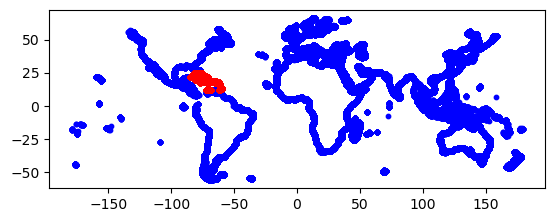

In [54]:





# Step 2: Visualize these 2 geospatial datasets on a map
fig, ax = plt.subplots()
data_points.plot(ax=ax, color='blue', markersize=10)
circle_center.plot(ax=ax, color='red', markersize=10)
buffer_circles.boundary.plot(ax=ax, color='red')
plt.show()


In [55]:
# search_radius=check_distance
lon_x=-69.07256	
lat_y=12.18975

# Create a bounding box geometry from the extent of buffer circles
xmin, ymin, xmax, ymax = circle_center.total_bounds
bbox = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
bbox = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# Spatially join data_points with the bounding box to select only the points within the extent of buffer circles
data_points_within_extent = gpd.sjoin(data_points, bbox, op='within')



c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [56]:
data_points_within_extent.head()

,changerate,continent,country,country_id,intercept,lat,lon,transect_geom,transect_id,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100,geometry,index_right
stations,,,,,,,,,,,,,,,
143659,0.483994,b'North America',Honduras,b'HND',908.867749,15.316086,-83.594050,"b'LINESTRING (-83.5940502715 15.3160860947, -8...",BOX_116_285_46,-1.044868,-0.770411,-1.355799,-1.433222,POINT (-83.59405 15.31609),0
143660,0.409464,b'North America',Honduras,b'HND',924.332157,15.320688,-83.607175,"b'LINESTRING (-83.6071747333 15.3206880114, -8...",BOX_116_285_49,-1.583743,-1.225980,-2.054674,-2.158385,POINT (-83.60717 15.32069),0
143661,0.292752,b'North America',Honduras,b'HND',934.129156,15.322247,-83.611365,"b'LINESTRING (-83.6113651877 15.32224744, -83....",BOX_116_285_50,-1.700455,-1.342565,-2.171386,-2.275096,POINT (-83.61137 15.32225),0
143662,0.210961,b'North America',Honduras,b'HND',945.102658,15.323807,-83.615556,"b'LINESTRING (-83.615555642 15.323806857, -83....",BOX_116_285_51,-1.782246,-1.424482,-2.253177,-2.356888,POINT (-83.61556 15.32381),0
143663,0.193768,b'North America',Honduras,b'HND',941.417181,15.325679,-83.620040,"b'LINESTRING (-83.62004022 15.3256789772, -83....",BOX_116_285_52,-1.799439,-1.441675,-2.270370,-2.374080,POINT (-83.62004 15.32568),0


In [57]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(0,len(buffer_circles['geometry'])),desc="Transects checked"):
    #inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]
    inside_points = data_points_within_extent[data_points_within_extent.within(buffer_circles.loc[i,'geometry'])]
    
    # Calculate distance
   
    inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])

    # Sort inside_points by 'distance' in ascending order
    sorted_inside_points = inside_points.sort_values(by='distance')

    # Select the top 2 rows
    nearest_point = sorted_inside_points.head(1)

    if len(inside_points['geometry'])==0:
            circle_center.loc[i,'sampled points']=0
            circle_center.loc[i,'slope']=np.nan
            continue
    
    if len(inside_points['geometry'])>0:
        circle_center.loc[i,'sampled points']=len(inside_points['geometry'])
        circle_center.loc[i,'Change_rate_SSP1_45_2050']=nearest_point["Change_rate_SSP1_45_2050"].values
        circle_center.loc[i,'Change_rate_SSP1_45_2100']=nearest_point["Change_rate_SSP1_45_2100"].values
        circle_center.loc[i,'Change_rate_SSP5_85_2050']=nearest_point["Change_rate_SSP5_85_2050"].values
        circle_center.loc[i,'Change_rate_SSP5_85_2100']=nearest_point["Change_rate_SSP5_85_2100"].values

        continue
# Suppress all warnings
warnings.filterwarnings("ignore")
circle_center

Transects checked: 100%|██████████| 37509/37509 [32:54<00:00, 19.00it/s]  


,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,geometry,sampled points,slope,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
0,BOX_116_353_2,COL,South America,Colombia,-71.874132,12.257491,-71.879805,12.250684,-71.885477,12.243877,POINT (-71.87980 12.25068),0.0,NaN,NaN,NaN,NaN,NaN
1,BOX_116_353_3,COL,South America,Colombia,-71.869660,12.252394,-71.876981,12.247308,-71.884303,12.242222,POINT (-71.87698 12.24731),0.0,NaN,NaN,NaN,NaN,NaN
2,BOX_116_353_4,COL,South America,Colombia,-71.866684,12.243923,-71.875632,12.243144,-71.884580,12.242366,POINT (-71.87563 12.24314),0.0,NaN,NaN,NaN,NaN,NaN
3,BOX_116_353_5,COL,South America,Colombia,-71.866286,12.239551,-71.875233,12.238772,-71.884181,12.237993,POINT (-71.87523 12.23877),0.0,NaN,NaN,NaN,NaN,NaN
4,BOX_116_353_6,COL,South America,Colombia,-71.865960,12.235759,-71.874835,12.234400,-71.883710,12.233041,POINT (-71.87483 12.23440),0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37504,BOX_139_002_61,DOM,North America,Dominican Republic,-71.660191,17.969154,-71.668186,17.965259,-71.676182,17.961363,POINT (-71.66819 17.96526),1.0,NaN,0.255533,0.261496,0.247684,0.245955
37505,BOX_139_002_62,DOM,North America,Dominican Republic,-71.657870,17.964549,-71.666228,17.961418,-71.674587,17.958286,POINT (-71.66623 17.96142),1.0,NaN,0.132781,0.138744,0.124932,0.123203
37506,BOX_139_002_63,DOM,North America,Dominican Republic,-71.656224,17.960573,-71.664583,17.957442,-71.672941,17.954311,POINT (-71.66458 17.95744),1.0,NaN,0.059195,0.065159,0.051347,0.049618
37507,BOX_139_002_64,DOM,North America,Dominican Republic,-71.654578,17.956598,-71.662937,17.953466,-71.671295,17.950335,POINT (-71.66294 17.95347),1.0,NaN,-0.060692,-0.054729,-0.068541,-0.070270


In [59]:
circle_center.describe()

,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,sampled points,slope,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
count,37509.000000,37509.000000,37509.000000,37509.000000,37509.000000,37509.000000,37509.000000,0.0,11597.000000,11597.000000,11597.000000,11597.000000
mean,-74.929397,20.570424,-74.929338,20.570453,-74.929276,20.570481,0.693993,NaN,-8.659977,-8.482749,-8.910055,-8.951153
std,6.112249,3.063988,6.112431,3.064050,6.112619,3.064127,1.446826,NaN,85.569057,85.560559,85.581022,85.583090
min,-84.942014,11.996820,-84.950876,12.000458,-84.959783,11.992212,0.000000,NaN,-1000.993207,-1000.635443,-1001.464138,-1001.567848
25%,-79.036895,18.443619,-79.037986,18.447064,-79.038147,18.450788,0.000000,NaN,-1.856096,-1.533089,-2.323517,-2.398780
50%,-76.242192,21.533002,-76.238532,21.531926,-76.237924,21.531264,0.000000,NaN,-0.785423,-0.623015,-1.004790,-1.054622
75%,-71.802978,22.683746,-71.803416,22.678425,-71.805816,22.674398,1.000000,NaN,-0.010880,0.009970,-0.033105,-0.037411
max,-59.431497,25.007935,-59.422593,24.999901,-59.413637,25.003622,17.000000,NaN,1029.561585,1029.904307,1029.073585,1028.998864


In [58]:
circle_center.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Shoreline_Change\Global_Erosion_rate_FC_shore_mon_fut_remapped.csv",index=False)

In [27]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Shoreline_Change\Global_Erosion_rate_FC_shore_mon_fut_remapped.csv")
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,geometry,sampled points,slope,Change_rate_SSP1_45_2050,Change_rate_SSP1_45_2100,Change_rate_SSP5_85_2050,Change_rate_SSP5_85_2100
0,BOX_116_353_2,COL,South America,Colombia,-71.874132,12.257491,-71.879805,12.250684,-71.885477,12.243877,POINT (-71.8798045985 12.250683718),0.0,NaN,NaN,NaN,NaN,NaN
1,BOX_116_353_3,COL,South America,Colombia,-71.869660,12.252394,-71.876981,12.247308,-71.884303,12.242222,POINT (-71.87698143850001 12.247308305),0.0,NaN,NaN,NaN,NaN,NaN
2,BOX_116_353_4,COL,South America,Colombia,-71.866684,12.243923,-71.875632,12.243144,-71.884580,12.242366,POINT (-71.8756318462 12.2431443263),0.0,NaN,NaN,NaN,NaN,NaN
3,BOX_116_353_5,COL,South America,Colombia,-71.866286,12.239551,-71.875233,12.238772,-71.884181,12.237993,POINT (-71.8752334021 12.2387721729),0.0,NaN,NaN,NaN,NaN,NaN
4,BOX_116_353_6,COL,South America,Colombia,-71.865960,12.235759,-71.874835,12.234400,-71.883710,12.233041,POINT (-71.8748349513 12.2343999454),0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37504,BOX_139_002_61,DOM,North America,Dominican Republic,-71.660191,17.969154,-71.668186,17.965259,-71.676182,17.961363,POINT (-71.6681862112 17.9652589019),1.0,NaN,0.255533,0.261496,0.247684,0.245955
37505,BOX_139_002_62,DOM,North America,Dominican Republic,-71.657870,17.964549,-71.666228,17.961418,-71.674587,17.958286,POINT (-71.6662284163 17.9614175026),1.0,NaN,0.132781,0.138744,0.124932,0.123203
37506,BOX_139_002_63,DOM,North America,Dominican Republic,-71.656224,17.960573,-71.664583,17.957442,-71.672941,17.954311,POINT (-71.664582619 17.9574419454),1.0,NaN,0.059195,0.065159,0.051347,0.049618
37507,BOX_139_002_64,DOM,North America,Dominican Republic,-71.654578,17.956598,-71.662937,17.953466,-71.671295,17.950335,POINT (-71.6629367897 17.953466310899998),1.0,NaN,-0.060692,-0.054729,-0.068541,-0.070270


In [29]:
import plotly.express as px

lat = 18.1
lon = -77.3
view_width = 10

df=df.loc[~df["Change_rate_SSP1_45_2050"].isna(),:]

# Plot using Plotly Express
fig = px.scatter_mapbox(df,
                        lat="Intersect_lat",
                        lon="Intersect_lon",
                        color="Change_rate_SSP1_45_2050",
                        range_color=(-2, 0.5),
                        hover_data="transect_id",
                        mapbox_style="carto-positron",width=2000,
                        height=1200)

# Update map layout to adjust center and zoom
fig.update_layout(mapbox=dict(center=dict(lat=lat+1, lon=lon+4), zoom=5.5),title=f"{df_rate.columns[-1]} Distribution along Caribbean's shoreline")
fig.show()

fig_name_shoreline=df_rate.columns[-1]+' shoreline_plot-RAW.png'


In [41]:
# import geopandas as gpd
# df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Sediment_type\Global_Sed_type.csv")
# data_points = gpd.GeoDataFrame(
#     df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
# )
# data_points